In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix, precision_score, recall_score,f1_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
import warnings
warnings.filterwarnings('ignore')

In [13]:
path = r"C:\Jernes\MLOPS_iris\data\raw\Iris.csv"

In [16]:
if not os.path.exists(path):
    raise FileNotFoundError(f'File not found in the specified path {path}')
df = pd.read_csv(path)

In [17]:
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [115]:
print(f'Dataset Shape :{df.shape}')
print('\nDataSet info:')
print(df.info())
print('\nMissing values in Dataset')
print(df.isnull().sum())

Dataset Shape :(150, 6)

DataSet info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB
None

Missing values in Dataset
Id               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64


In [117]:
df.select_dtypes(include=object).columns

Index(['Species'], dtype='object')

In [119]:
df.select_dtypes(include='number').columns

Index(['Id', 'SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm'], dtype='object')

In [18]:
numeric_columns = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
target_column = 'Species'

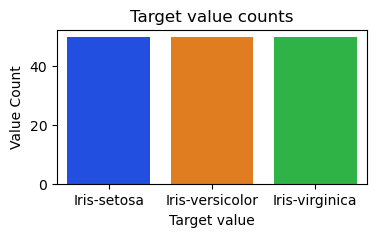

In [123]:
plt.figure(figsize=(4,2))
sns.countplot(x=target_column, data=df, palette='bright')
plt.xlabel('Target value')
plt.ylabel('Value Count')
plt.title('Target value counts')
plt.show()

In [19]:
df.drop(columns='Id', inplace=True)

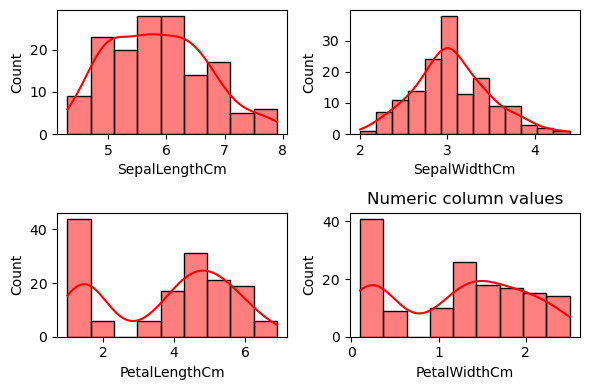

In [127]:
plt.figure(figsize=(6,4))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(2,2,i)
    sns.histplot(x=col, data=df, kde=True, color= 'red')
    plt.xlabel(col)
    plt.ylabel('Count')
plt.title('Numeric column values')
plt.tight_layout()
plt.show()

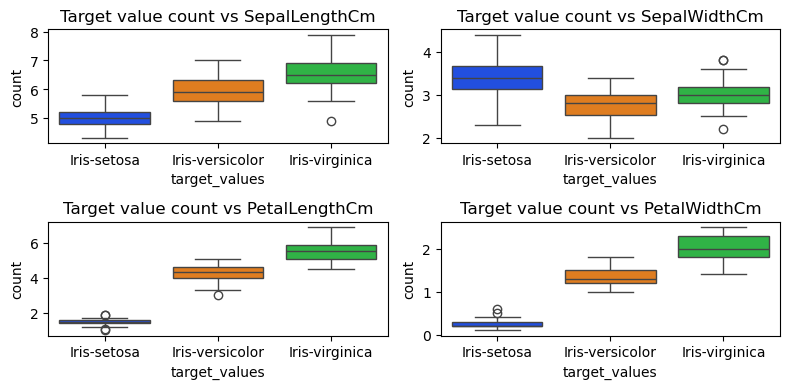

In [129]:
plt.figure(figsize=(8,4))
for i , col in enumerate(numeric_columns, 1):
    plt.subplot(2,2,i)
    sns.boxplot(x=target_column, y=col, data=df, palette='bright')
    plt.xlabel('target_values')
    plt.ylabel('count')
    plt.title(f'Target value count vs {col}')
plt.tight_layout()
plt.show()

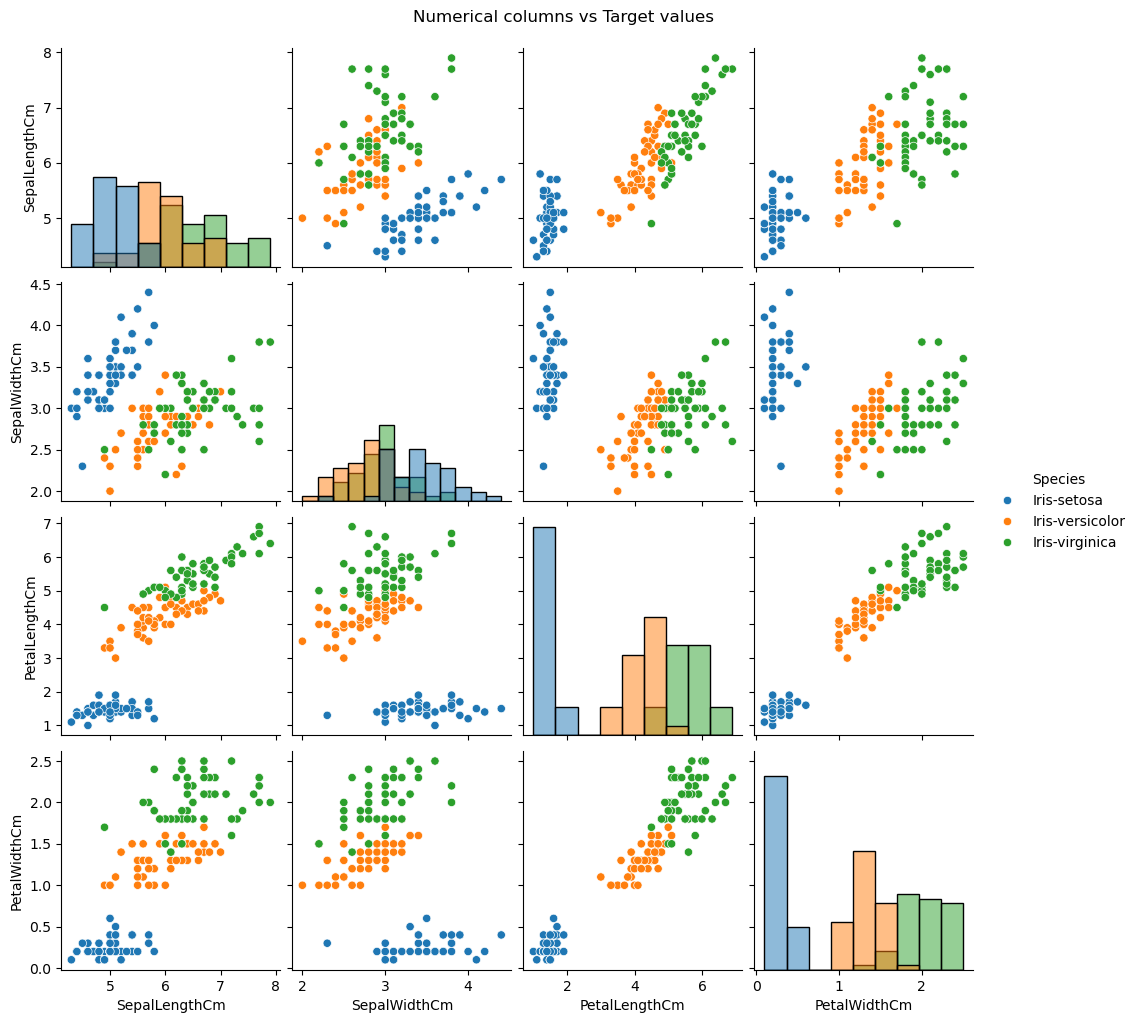

In [131]:
sns.pairplot(data=df, hue=target_column, diag_kind='hist')
plt.suptitle('Numerical columns vs Target values', y= 1.02)
plt.show()

<Axes: >

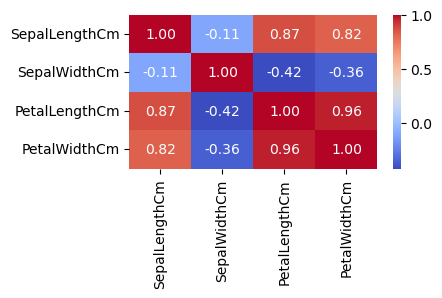

In [133]:
plt.figure(figsize=(4,2))
sns.heatmap(df[numeric_columns].corr(),  annot=True, cmap='coolwarm', fmt='.2f')

In [20]:
le = LabelEncoder()
df[target_column] = le.fit_transform(df[target_column])
print(f'Encoded : {(dict(zip(le.classes_,le.transform(le.classes_))))}')

Encoded : {'Iris-setosa': np.int64(0), 'Iris-versicolor': np.int64(1), 'Iris-virginica': np.int64(2)}


In [21]:
#Assinging X Y values
x = df.drop(columns=target_column)
y = df[target_column]

#Spliting train test
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=29)

#Creating Logistic model without any feature engineering
model_logisitic = LogisticRegression()
model_logisitic.fit(x_train, y_train)
y_pred = model_logisitic.predict(x_test)
accuracy_score_logisitic = accuracy_score(y_pred,y_test)

print(f'Logisitic Regression accuracy score without any feature engineering or hyperparamater tunning or stackclassifier : {accuracy_score_logisitic}')

Logisitic Regression accuracy score without any feature engineering or hyperparamater tunning or stackclassifier : 0.9333333333333333


In [22]:
#Handling outliers with clip method
for col in numeric_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    Lower_bound = IQR - 1.5 * Q1
    Upper_bound = IQR + 1.5 * Q3
    df[col] = df[col].clip(lower=Lower_bound, upper=Upper_bound)

# Assigning X and Y
x = df.drop(columns=target_column)
y = df[target_column]

#Train Test split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=29)

#Creating Dataframe for train and test
x_train = pd.DataFrame(x_train, columns=x.columns)
x_test = pd.DataFrame(x_test, columns=x.columns)

#Interaction Features
x_train['Sepal_area'] = (0.785 * (x_train['SepalLengthCm']/2) * (x_train['SepalWidthCm']/2))
x_train['Petal_volume'] =(0.785 * (x_train['PetalLengthCm']/2) * (x_train['PetalWidthCm']/2))
x_test['Sepal_area'] = (0.785 * (x_test['SepalLengthCm']/2) * (x_test['SepalWidthCm']/2))
x_test['Petal_volume'] =(0.785 * (x_test['PetalLengthCm']/2) * (x_test['PetalWidthCm']/2))

#qcutting
x_train['Sepal_area'] = pd.qcut(x_train['Sepal_area'], q=3, labels=['low','medium','high'], duplicates='drop')
x_train['Petal_volume'] = pd.qcut(x_train['Petal_volume'], q=3, labels=['low','medium','high'], duplicates='drop')
x_test['Sepal_area'] = pd.qcut(x_test['Sepal_area'], q=3, labels=['low','medium','high'], duplicates='drop')
x_test['Petal_volume'] = pd.qcut(x_test['Petal_volume'], q=3, labels=['low','medium','high'], duplicates='drop')

#one-hot encoding
x_train = pd.get_dummies(x_train, columns=['Sepal_area'], drop_first=True)
x_test = pd.get_dummies(x_test, columns=['Sepal_area'], drop_first= True)
x_train = pd.get_dummies(x_train, columns=['Petal_volume'], drop_first=True)
x_test = pd.get_dummies(x_test, columns=['Petal_volume'], drop_first=True)

#creating list with newly created columns name
binned_columns = ['Sepal_area_medium', 'Sepal_area_high', 'Petal_volume_medium','Petal_volume_high']

#Label encoding for new features
for col in binned_columns:
    x_train[col] = le.fit_transform(x_train[col])
    print(f'Encoded in x_train : {dict(zip(le.classes_,le.transform(le.classes_)))}')
    x_test[col] = le.fit_transform(x_test[col])
    print(f'Encoded in x_test : {dict(zip(le.classes_,le.transform(le.classes_)))}')

#Model creation with list of models
models = {
    'logistic':LogisticRegression(max_iter=1000),
    'svm':SVC(),
    'rf':RandomForestClassifier(random_state=29),
    'dt':DecisionTreeClassifier(random_state=29),
    'xgb':XGBClassifier(random_state=29),
    'nb':MultinomialNB()
    }

#Accuracy evaluation
accuarcy_scores = {}
test_accuarcy_scores = {}

for name, model in models.items():
    scores = cross_val_score(model,x_train,y_train,scoring='accuracy')
    accuarcy_scores[name] = scores.mean()
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    test_accuracy = accuracy_score(y_test,y_pred)
    test_accuarcy_scores[name] = test_accuracy

#creatinf Dataframe with results
result_df =pd.DataFrame({
    'model':list(models.keys()),
    'Train_accuracy':[accuarcy_scores[name] for name in models.keys()],
    'Test_accuracy':[test_accuarcy_scores[name] for name in models.keys()]
})

#Sorting high accuracy value
result_df = result_df.sort_values(by=['Test_accuracy'],ascending=[False])
print(result_df)

Encoded in x_train : {np.False_: np.int64(0), np.True_: np.int64(1)}
Encoded in x_test : {np.False_: np.int64(0), np.True_: np.int64(1)}
Encoded in x_train : {np.False_: np.int64(0), np.True_: np.int64(1)}
Encoded in x_test : {np.False_: np.int64(0), np.True_: np.int64(1)}
Encoded in x_train : {np.False_: np.int64(0), np.True_: np.int64(1)}
Encoded in x_test : {np.False_: np.int64(0), np.True_: np.int64(1)}
Encoded in x_train : {np.False_: np.int64(0), np.True_: np.int64(1)}
Encoded in x_test : {np.False_: np.int64(0), np.True_: np.int64(1)}
      model  Train_accuracy  Test_accuracy
3        dt        0.941667       0.900000
4       xgb        0.941667       0.866667
1       svm        0.950000       0.800000
0  logistic        0.966667       0.800000
2        rf        0.950000       0.800000
5        nb        0.941667       0.800000


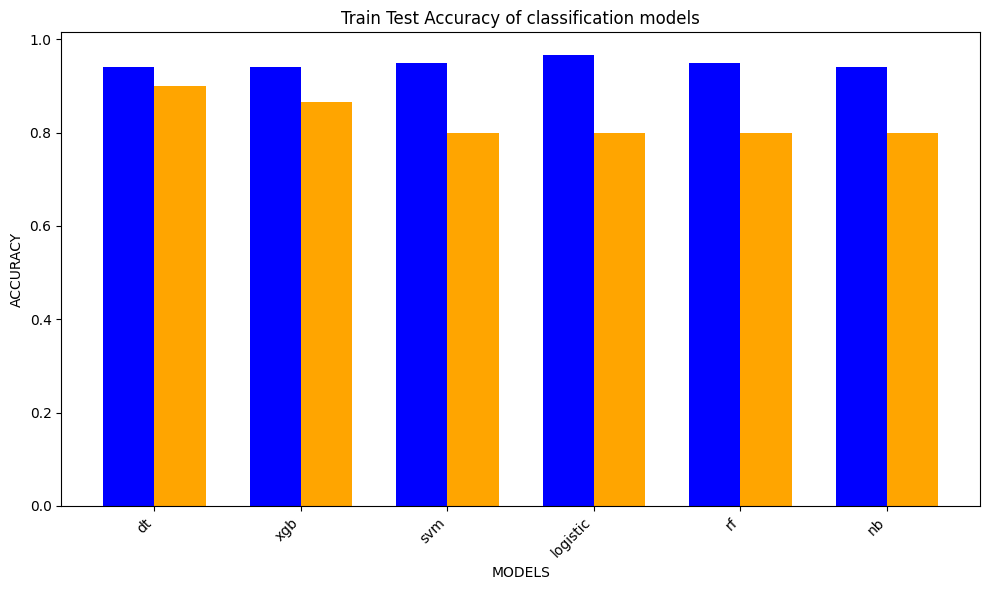

In [23]:
fig, ax = plt.subplots(figsize=(10,6))
bar_width = 0.35

train_accuracy = result_df['Train_accuracy']
test_accuracy = result_df['Test_accuracy']
model_names = result_df['model']


r1 = np.arange(len(model_names))
r2 = [x + bar_width for x in r1]

ax.bar(r1, train_accuracy, color ='blue', width=bar_width)
ax.bar(r2, test_accuracy, color = 'orange', width = bar_width)

ax.set_xlabel("MODELS")
ax.set_ylabel("ACCURACY")
ax.set_title("Train Test Accuracy of classification models")
ax.set_xticks([r+bar_width/2 for r in r1])
ax.set_xticklabels(model_names, rotation = 45, ha='right')

plt.tight_layout()
plt.show()

In [24]:
models1 = {
    'logistic': {
        'model': LogisticRegression(max_iter=100),
        'use_scaled': True,
        'params': {
            'C': np.logspace(-4, 4, 10),
            'solver': ['liblinear', 'lbfgs']
        }
    },

    'svm': {
        'model': SVC(),
        'use_scaled': True,
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'kernel': ['rbf', 'linear'],
            'gamma': ['scale', 'auto']
        }
    },

    'dt': {
        'model': DecisionTreeClassifier(random_state=29),
        'use_scaled': False,
        'params': {
            'max_depth': [None, 5, 10, 15, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },

    'rf': {
        'model': RandomForestClassifier(random_state=29),
        'use_scaled': False,
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            'max_features': ['sqrt', 'log2']
        }
    },

    'xgb': {
        'model': XGBClassifier(random_state=29, use_label_encoder=False, eval_metric='logloss'),
        'use_scaled': False,
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 6, 10],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'gamma': [0, 0.1, 0.2]
        }
    }
}

In [25]:
results_hyper = []

for model_name, mp in models1.items():
    clf = RandomizedSearchCV(mp['model'], mp['params'], cv=2, n_iter=20, scoring='accuracy', n_jobs=-1, random_state=29)
    clf.fit(x_train,y_train)
    results_hyper.append({
     'model':model_name,
     'best_score':clf.best_score_,
    'best_params':clf.best_params_
    })

In [26]:
df_results_hyper = pd.DataFrame(results_hyper)

In [27]:
df_results_hyper

,model,best_score,best_params
0,logistic,0.975000,"{'solver': 'lbfgs', 'C': 1291.5496650148827}"
1,svm,0.975000,"{'kernel': 'linear', 'gamma': 'scale', 'C': 1}"
2,dt,0.950000,"{'min_samples_split': 10, 'min_samples_leaf': ..."
3,rf,0.966667,"{'n_estimators': 200, 'min_samples_split': 2, ..."
4,xgb,0.966667,"{'subsample': 1.0, 'n_estimators': 100, 'max_d..."


In [28]:
models_hyper = {
    'logistic':LogisticRegression(**df_results_hyper.loc[df_results_hyper['model']=='logistic']['best_params'].iloc[0], random_state=29),
    'svm':SVC(**df_results_hyper.loc[df_results_hyper['model']=='svm']['best_params'].iloc[0],random_state=29),
    'rf':RandomForestClassifier(**df_results_hyper.loc[df_results_hyper['model']=='rf']['best_params'].iloc[0],random_state=29),
    'dt':DecisionTreeClassifier(**df_results_hyper.loc[df_results_hyper['model']=='dt']['best_params'].iloc[0],random_state=29),
    'xgb':XGBClassifier(**df_results_hyper.loc[df_results_hyper['model']=='xgb']['best_params'].iloc[0],random_state=29)
    }

In [29]:
accuarcy_scores_hyper = {}
test_accuarcy_scores_hyper = {}

for name, model in models_hyper.items():
    scores_hyper = cross_val_score(model, x_train, y_train, scoring='accuracy')
    accuarcy_scores_hyper[name] = scores_hyper.mean()
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    test_accuarcy = accuracy_score(y_test,y_pred)
    test_accuarcy_scores_hyper[name] = test_accuarcy

In [30]:
df_result_hyper1 = pd.DataFrame({
    'models':list(models_hyper.keys()),
    'Train_accuracy_hyper':[accuarcy_scores_hyper[name] for name in models_hyper.keys()],
    'Test_accuracy_hyper' :[test_accuarcy_scores_hyper[name] for name in models_hyper.keys()]
})
df_results_hyper1 = df_result_hyper1.sort_values(by='Test_accuracy_hyper',ascending=False)

In [31]:
df_results_hyper1

,models,Train_accuracy_hyper,Test_accuracy_hyper
0,logistic,0.983333,0.900000
1,svm,0.983333,0.900000
3,dt,0.950000,0.900000
4,xgb,0.958333,0.900000
2,rf,0.958333,0.833333


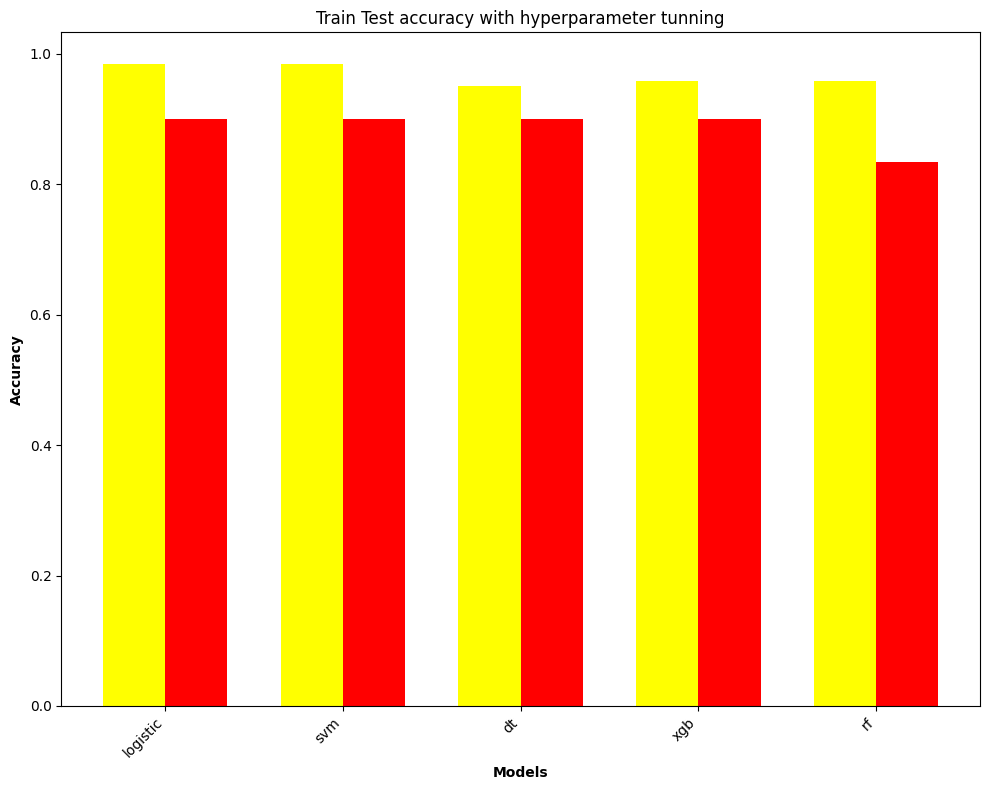

In [32]:
fig, ax = plt.subplots(figsize=(10,8))
bar_width = 0.35

train_accuracy_hyper =df_results_hyper1['Train_accuracy_hyper']
test_accuarcy_hyper = df_results_hyper1['Test_accuracy_hyper']
model_names = df_results_hyper1['models']

r1 = np.arange(len(model_names))
r2 = [x+bar_width for x in r1]

ax.bar(r1, train_accuracy_hyper, color ='yellow', width=bar_width, label='Train_accuracy')
ax.bar(r2, test_accuarcy_hyper, color ='red', width=bar_width, label='Test_accuracy')

ax.set_xlabel('Models',fontweight='bold')
ax.set_ylabel('Accuracy',fontweight='bold')
ax.set_title("Train Test accuracy with hyperparameter tunning")
ax.set_xticks([x+bar_width/2 for x in r1])
ax.set_xticklabels(model_names, rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [33]:
#Stacking
estimators=[
    ('svm',SVC(probability=True)),
    ('rf',RandomForestClassifier(random_state=29)),
    ('dt',DecisionTreeClassifier(random_state=29)),
    ('xgb',XGBClassifier(random_state=29))
]

In [34]:
stacking_model =StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=1000),n_jobs=-1)
stacking_model.fit(x_train,y_train)
y_pred= stacking_model.predict(x_test)
accuarcy_scores123 = accuracy_score(y_test,y_pred)

In [35]:
accuarcy_scores123

0.8